# Model Construction

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

## Data Preparation & Target Transformation

In [2]:
period = 4
forward = pd.read_parquet('../input/kline-daily/market_daily.parquet')
forward = forward.adjclose.groupby(level=1).shift(-1 - period) / forward.adjopen.groupby(level=1).shift(-1) - 1
forward = forward.dropna().unstack()
forward = forward.mask(forward <= 0., 0).mask(forward > 0.0, 1)
forward.head()

order_book_id,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603170.XSHG,688332.XSHG,688231.XSHG,688375.XSHG,001336.XSHE,603211.XSHG,688382.XSHG,301306.XSHE,001258.XSHE,688253.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
features_dir = '../input/features/'
features = list(filter(lambda x: x.endswith('.parquet'), os.listdir('../input/features/')))

datas = []
for feat in features:
    data = pd.read_parquet(features_dir + feat)
    data_med = data.median(axis=1)
    mad = data.subtract(data_med, axis=0).abs().median(axis=1)

    data = data.clip(data_med - 5 * mad, data_med + 5 * mad, axis=0)
    data = data.subtract(data.mean(axis=1), axis=0).divide(data.std(axis=1), axis=0)
    data = data.fillna(0, axis=0)
    datas.append(data)

In [4]:
train_dataset = datas + [forward]
train_dataset = pd.concat(train_dataset, axis=0, keys=[feat[:-8] for feat in features] + ['target'])
train_dataset = train_dataset.swaplevel().sort_index()
train_dataset.head()

,,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688819.XSHG,688981.XSHG,689009.XSHG,301269.XSHE,603201.XSHG,688130.XSHG,301195.XSHE,301278.XSHE,301333.XSHE,688371.XSHG
2010-01-04,target,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,target,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,target,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,target,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,std_turnover_5d,-0.730673,-0.80119,-1.226496,1.335868,-0.482916,-0.525347,-1.226496,0.693582,-0.49605,-0.017796,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


<AxesSubplot:>

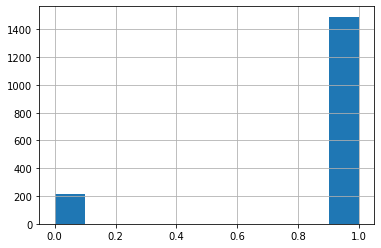

In [5]:
forward.loc["2010-01-11"].hist()

## Model Constructing

In [6]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

The following function provides a method for training a model on a given day

In [7]:
def fit_for_one_day(date: str, forward_period: int, training_period: int):
    i = train_dataset.index.levels[0].get_loc(date)
    training_end = train_dataset.index.levels[0][i - forward_period - 1]
    training_start = train_dataset.index.levels[0][i - forward_period - training_period - 1]
    csdata = train_dataset.loc[training_start:training_end].unstack().stack(level=0).dropna()
    if csdata.columns.size > 1:
        pca = PCA()
        train_x_pca = pd.DataFrame(pca.fit_transform(csdata.loc[:, csdata.columns != 'target']), index=csdata.index)
        model = RandomForestClassifier()
        model.fit(train_x_pca, csdata['target'])
        return model, csdata.columns[csdata.columns != 'target']
    return [None, None]

In [8]:
forward_period = period
training_period = period
dates = train_dataset.index.levels[0][forward_period + training_period + 1:]
models = []
for date in tqdm(dates):
    models.append(fit_for_one_day(date, forward_period, training_period))

 72%|███████▏  | 2210/3050 [1:13:21<41:46,  2.98s/it]

: 

: 

Constructing a model time series

In [50]:
models = []
features = []
forward_index_str = forward.index.intersection(total_feature.index.levels[0]).strftime('%Y%m%d')

for date in tqdm(forward_index_str):
    model, feat = fit_for_one_day(date)
    models.append(model)
    features.append(feat)

100%|██████████| 509/509 [02:18<00:00,  3.67it/s]


Use the model on the last relocate date to predict the next period's forward return

In [86]:
valuation = pd.Series(index=forward_index_str[1:], dtype='float32')
predictions = pd.DataFrame(index=forward_index_str, columns=total_feature.columns)
for i in range(len(forward_index_str) - 1):
    date = forward_index_str[i + 1]
    if features[i].isin(total_feature.loc[date].index).all():
        data = pd.concat([total_feature.loc[date].T.loc[:, features[i]], forward.loc[date]], axis=1).dropna()
        model = models[i]
        y_pred = pd.Series(model.predict(data.loc[:, features[i]].values), index=data.index)
        valuation.loc[date] = accuracy_score(data.iloc[:, -1].values, y_pred.values)
        predictions.loc[date] = y_pred
    else:
        valuation.loc[date] = np.nan

Visualization and valuation

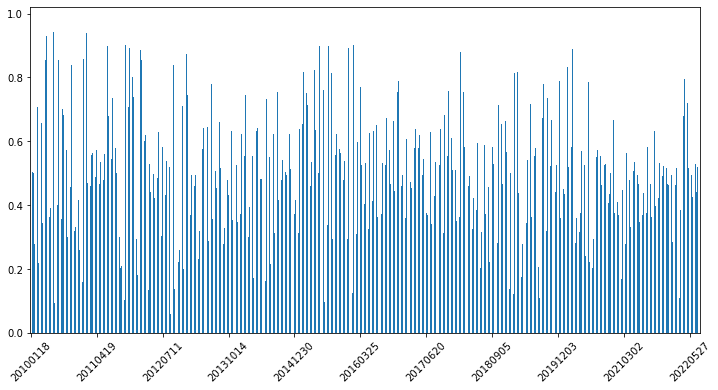

In [87]:
ax = valuation.plot.bar(figsize=(12, 6))
ax.set_xticks(ax.get_xticks()[::50])
_ = ax.set_xticklabels(valuation.index[::50], rotation=45)

In [88]:
(valuation.mean(), valuation.std(), valuation.mean() / valuation.std(), 
    valuation[valuation > valuation.mean()].size / valuation.size, ttest_1samp(valuation.dropna(), 0.5))

(0.5045878,
 0.19100636,
 2.6417332,
 0.5039370078740157,
 Ttest_1sampResult(statistic=0.5408332243728112, pvalue=0.5888605362894317))

Prediction Matrix

In [90]:
predictions.head()

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688819.XSHG,688981.XSHG,689009.XSHG,301269.XSHE,603201.XSHG,688130.XSHG,301195.XSHE,301278.XSHE,301333.XSHE,688371.XSHG
20100108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100118,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100203,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20100211,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
